In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import gc
import time

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
import seaborn as sns

from pandarallel import pandarallel
pandarallel.initialize()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
train_sms = pd.read_pickle('after_reducion/train_sms.pkl')
test_sms = pd.read_pickle('after_reducion/test_sms.pkl')

train_user = pd.read_pickle('after_reducion/train_user.pkl')
test_user = pd.read_pickle('after_reducion/test_user.pkl')

In [3]:
train_label = train_user[['phone_no_m','label']]

In [15]:

'''

观察诈骗电话与sms之间的数量关系
因为考虑到要针对电话号码做特征，所以 以 label 为x轴， sms数目为y轴

    1. 可以看到，一般来讲都是 接受信息比较多。
            而发送信息： 诈骗电话 >> 正常电话
            而接受信息： 诈骗电话 << 正常电话
            
            所以可能的特征有，某个电话的发送信息数目 / 接受信息的数目，做一个比率
                        注意这里是一个特征
        根据四个箱型图可以看出，
                接受信息量 / 发信息量  ， 高的多数为正常电话，低的多为诈骗电话
'''


a = pd.merge(train_sms,train_label,on='phone_no_m',how='inner')
a = pd.merge(a,train_label,left_on='opposite_no_m',right_on='phone_no_m',how='left')
a.drop(columns='phone_no_m_y',inplace=True)
a.rename(columns={'phone_no_m_x':'phone_no_m'},inplace=True)

In [16]:
# 1. 诈骗电话与发送信息的数量关系
b = pd.concat([pd.DataFrame(a[(a['label_x'] == 1)].sms_calltype_id.value_counts()),pd.DataFrame(a[(a['label_x'] == 0)].sms_calltype_id.value_counts())],axis=0)

b.reset_index(inplace=True)
b['sms_type']  = ['fraud','fraud','normal','normal']


b.columns=['sms_type','sms_num','label']
b['sms_type'] = ['passive','active','passive','active']

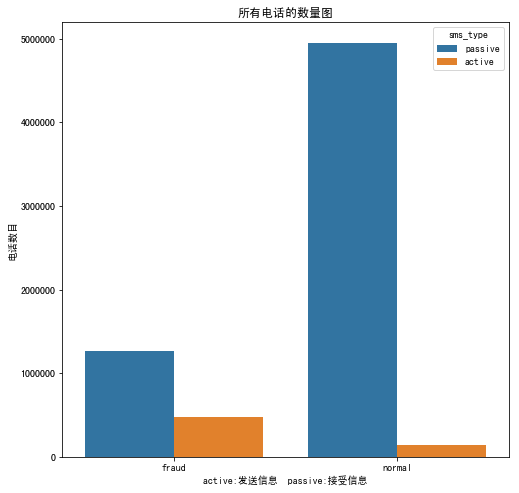

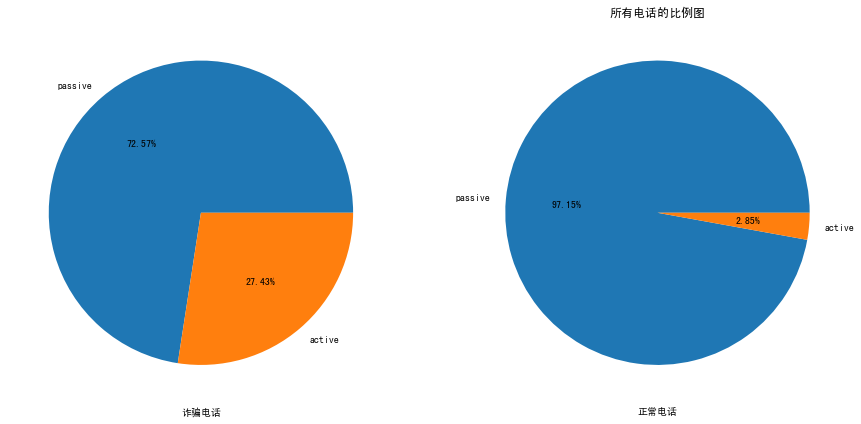

In [17]:

# 所有电话的数量图
fig,ax = plt.subplots(1,1,figsize=(8,8))
sns.barplot(x=b['label'],y=b['sms_num'],ax=ax,hue=b['sms_type'])
ax.set_xlabel('active:发送信息  passive:接受信息')
ax.set_ylabel('电话数目')
plt.title('所有电话的数量图')
plt.show()

b.loc[:1,'sms_num'] = b.loc[:1,'sms_num']/a[(a['label_x'] == 1)].shape[0]
b.loc[2:,'sms_num'] = b.loc[2:,'sms_num']/a[(a['label_x'] == 0)].shape[0]

# 所有电话的比例图
fig,ax = plt.subplots(1,2,figsize=(15,15))
ax[0].pie(b[:2]['sms_num'],labels=b[:2]['sms_type'],autopct='%1.2f%%')
ax[0].set_xlabel('诈骗电话')

ax[1].pie(b[2:]['sms_num'],labels=b[2:]['sms_type'],autopct='%1.2f%%')
ax[1].set_xlabel('正常电话')
plt.title('所有电话的比例图')
plt.show()

In [18]:
# 进一步观察详细的和数量关系
# 观察每个电话号码的平均发送信息和接受信息次数， 再跟label结合对比
a.drop(columns='label_y',inplace=True)


In [19]:
b = a.groupby(['phone_no_m','label_x','sms_calltype_id']).count().reset_index().set_index('phone_no_m')
b.dropna(inplace=True)  # Nan代表没这个行为
b['label_x'] = b['label_x'].apply(lambda x:'fraud' if x == 1 else 'normal')
b['sms_calltype_id'] = b['sms_calltype_id'].apply(lambda x:'active_sms' if x == 1 else 'passive_sms')

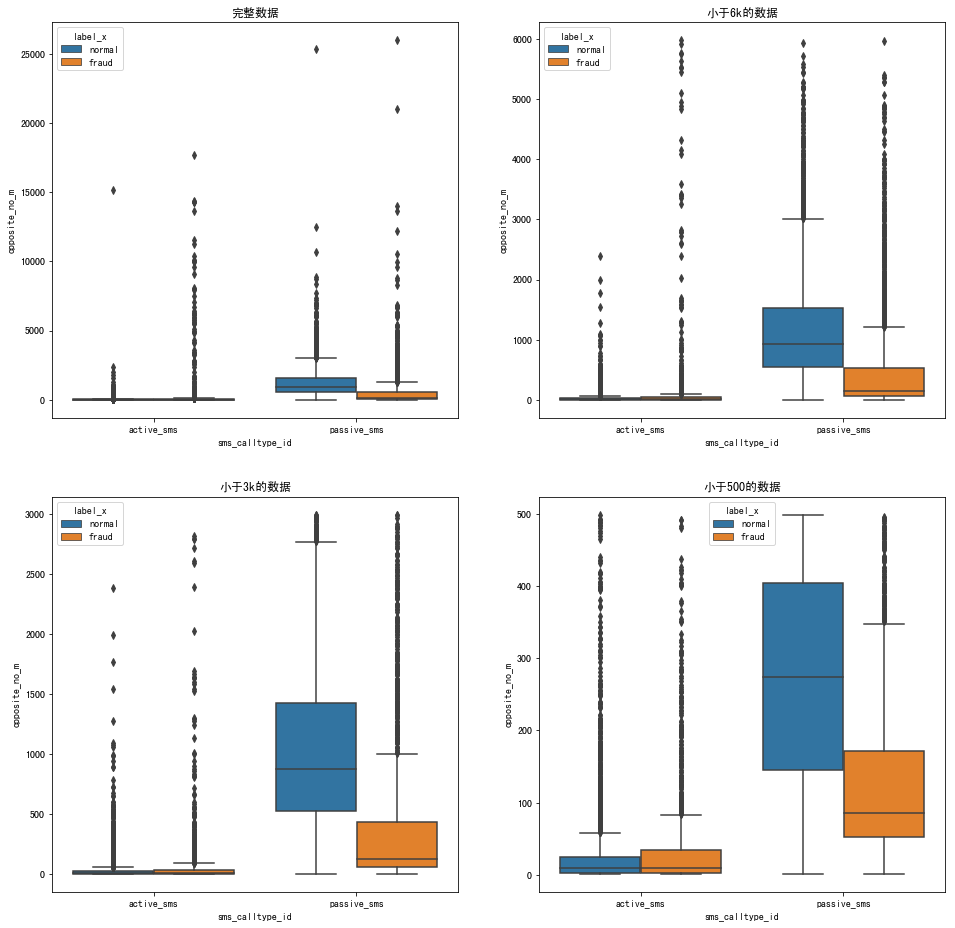

In [20]:
fig,ax = plt.subplots(2,2,figsize=(16,16))
sns.boxplot(y=b['opposite_no_m'],x=b['sms_calltype_id'],hue=b['label_x'],ax=ax[0][0])
ax[0][0].set_title('完整数据')


b = b[b['opposite_no_m']<6000]
sns.boxplot(y=b['opposite_no_m'],x=b['sms_calltype_id'],hue=b['label_x'],ax=ax[0][1])
ax[0][1].set_title('小于6k的数据')


b = b[b['opposite_no_m']<3000]
sns.boxplot(y=b['opposite_no_m'],x=b['sms_calltype_id'],hue=b['label_x'],ax=ax[1][0])
ax[1][0].set_title('小于3k的数据')


# 重点观察发短信的
b = b[b['opposite_no_m']<500]
sns.boxplot(y=b['opposite_no_m'],x=b['sms_calltype_id'],hue=b['label_x'],ax=ax[1][1])
ax[1][1].set_title('小于500的数据')

plt.show()




In [25]:
b

,label_x,sms_calltype_id,opposite_no_m,request_datetime
phone_no_m,,,,
00073ceecc0f7220a440580ac5dea410c90d14b666945839292d187d300bca49f991e0ee9f1c477b28d30b8f656a4421d236a19d67a78e17d25bd0935763076a,normal,active_sms,3.0,3.0
00073ceecc0f7220a440580ac5dea410c90d14b666945839292d187d300bca49f991e0ee9f1c477b28d30b8f656a4421d236a19d67a78e17d25bd0935763076a,normal,passive_sms,494.0,494.0
00086f1d2e2c1227f811c3e17f2e9c37cf9971f47bb933bfa515404062315e50e19902c0bcaa98411be0f060800eb5af1b061c53893349f5204486936121cbcd,fraud,active_sms,10.0,10.0
000c00db8809c27e723ba90582bf334b2d3ca9063f53fbcc24a0d5a76deb43a3696e0de84f9824c3f69762718f050f1391e30c7eeb6af558c306c8a326299a9e,fraud,active_sms,16.0,16.0
000c00db8809c27e723ba90582bf334b2d3ca9063f53fbcc24a0d5a76deb43a3696e0de84f9824c3f69762718f050f1391e30c7eeb6af558c306c8a326299a9e,fraud,passive_sms,81.0,81.0
...,...,...,...,...
ffd3a62b9204a8695140a7f04d2bf821c53b1e798fd9382de87b2928e016b03694bcdad0776c79ad569326a086e92811b710cb64cdae6606b64950b4f0421cbf,normal,passive_sms,309.0,309.0
ffdbcf9285b71d560a7c79445700db2c363b066003a73d9a998622a547f8808744879aaa11bbe5b13cd75a6e58f487067cf747991c0e3ff1e502f7c275e5a935,normal,active_sms,440.0,440.0
ffdf60d18dbbc25bb8c1697f7c97e8547517b2523d7001afd1e28cb0b3c3b3c39339fbb6e38c27be6049ab54923fbe30824442d51439c3a2e9a8e054dcb4a13a,normal,active_sms,1.0,1.0


,phone_no_m,opposite_no_m,sms_calltype_id,request_datetime,label_x
0,0251387744988114430181c3e680a3733001a26fe686bd...,df22edbc0e3dd6bc4f2f453e687b743e8442a54834b64f...,2,2019-08-01 12:13:08,1
1,0251387744988114430181c3e680a3733001a26fe686bd...,df22edbc0e3dd6bc4f2f453e687b743e8442a54834b64f...,2,2019-08-01 12:13:08,1
2,0251387744988114430181c3e680a3733001a26fe686bd...,df22edbc0e3dd6bc4f2f453e687b743e8442a54834b64f...,2,2019-08-01 12:13:08,1
3,0251387744988114430181c3e680a3733001a26fe686bd...,df22edbc0e3dd6bc4f2f453e687b743e8442a54834b64f...,2,2019-08-05 12:27:21,1
4,0251387744988114430181c3e680a3733001a26fe686bd...,df22edbc0e3dd6bc4f2f453e687b743e8442a54834b64f...,2,2019-08-05 12:27:21,1
...,...,...,...,...,...
6848504,11f8e59a3a93796582fadfe22b3bc77b416097c0a3822a...,730ec1945fb2860ff65747501909503d47970aec2b35ae...,1,2019-11-11 08:47:10,1
6848505,11f8e59a3a93796582fadfe22b3bc77b416097c0a3822a...,df22edbc0e3dd6bc4f2f453e687b743e8442a54834b64f...,2,2019-11-13 11:07:27,1
6848506,11f8e59a3a93796582fadfe22b3bc77b416097c0a3822a...,df22edbc0e3dd6bc4f2f453e687b743e8442a54834b64f...,2,2019-11-13 11:07:27,1
6848507,11f8e59a3a93796582fadfe22b3bc77b416097c0a3822a...,df22edbc0e3dd6bc4f2f453e687b743e8442a54834b64f...,2,2019-11-13 11:07:27,1


In [27]:
del a
gc.collect()

19048

In [31]:
train_sms.isnull().sum()

phone_no_m          0
opposite_no_m       0
sms_calltype_id     0
request_datetime    0
dtype: int64

In [33]:
# 这里只是做了一个特征的可视化分析，并没有添加特征，可以等到后面用过滤法来计算
train_sms.to_pickle('after_EDA/train_sms.pkl')
test_sms.to_pickle('after_EDA/test_sms.pkl')

